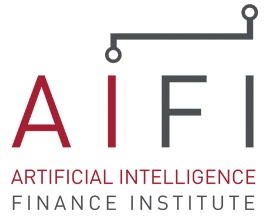


# Bootcamp - Supervised Machine Learning

# Ray Core


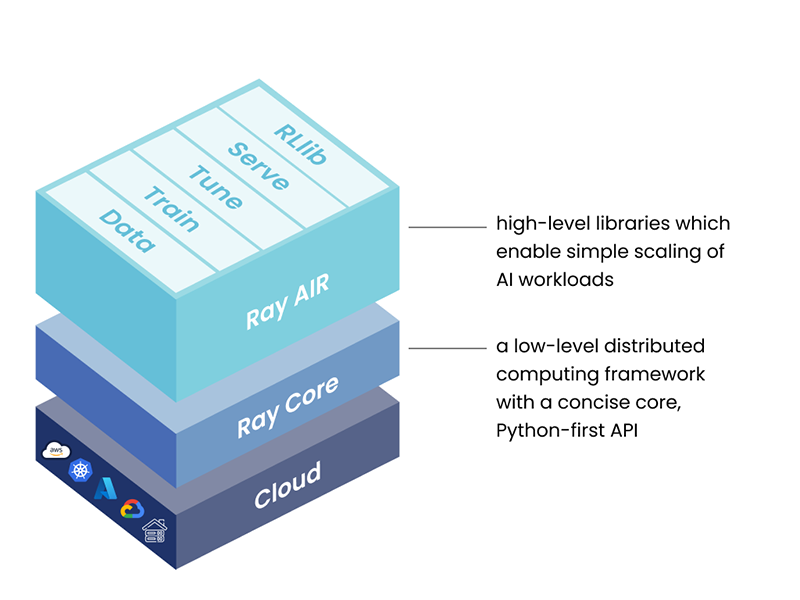

# Imports

In [1]:
%%capture
!pip install ray

In [ ]:
import ray
import time
import yfinance as yf
import numpy as np
from typing import Dict
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

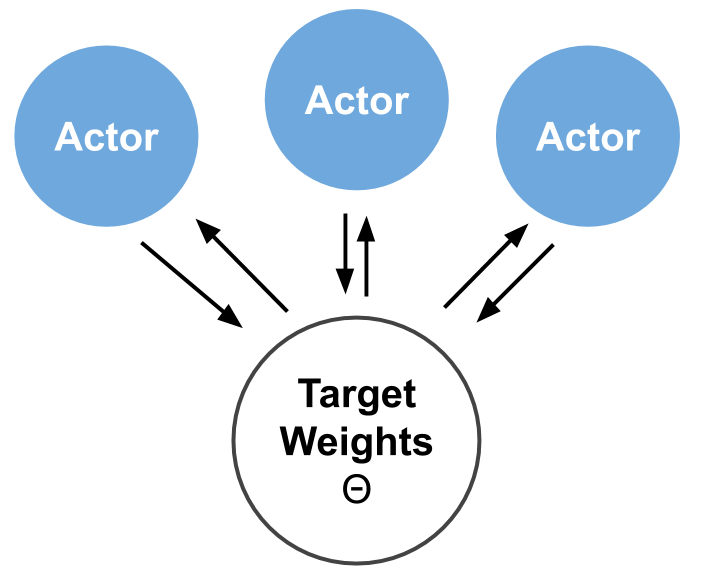

Actors extend the Ray API from functions (tasks) to classes. An actor is essentially a stateful worker (or a service). When a new actor is instantiated, a new worker is created, and methods of the actor are scheduled on that specific worker and can access and mutate the state of that worker. Like tasks, actors support CPU, GPU, and custom resource requirements.

## Training different linear regression models for each stock in parallel

The code first fetches the historical prices for the specified stocks using yfinance. It then splits this data into training and test sets, trains a linear regression model on the training set, and finally calculates the model's $R^2$ score on the test set.

This is done in parallel for all specified stocks, which can greatly speed up the process if you're dealing with a large number of stocks.


__Note__: The code as is assumes that you have at least 4 CPU cores available. If you're running this on a machine with fewer cores, please adjust the num_cpus parameter in the ray.init() call accordingly.

In [ ]:
ray.init(num_cpus=4)  # Adjust based on your machine's capabilities

@ray.remote
def fetch_and_train(symbol):
    # Fetch data
    data = yf.download(symbol, start='2022-01-01', end='2023-01-01')

    # Preprocess data
    data = data.dropna()
    X = data[['High', 'Low', 'Open']]
    y = data['Adj Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Validate model
    score = model.score(X_test, y_test)

    return symbol, score, model.coef_

In [4]:
symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

futures = [fetch_and_train.remote(symbol) for symbol in symbols]
results = ray.get(futures)

for symbol, score, coefs in results:
    print(f"\nStock: {symbol}\nScore: {score}\nCoefficients: {coefs}")

ray.shutdown()


2023-07-21 02:43:49,893	INFO worker.py:1621 -- Started a local Ray instance.


[*********************100%***********************]  1 of 1 completed

Stock: AAPL
Score: 0.9934039912030375
Coefficients: [ 0.80553061  0.94713988 -0.78046066]

Stock: GOOG
Score: 0.9974598868020693
Coefficients: [ 0.8781335   0.86213481 -0.73979454]

Stock: MSFT
Score: 0.9949797042158879
Coefficients: [ 0.87183051  0.87979934 -0.78003546]

Stock: AMZN
Score: 0.9964022476936298
Coefficients: [ 0.81344299  0.91299433 -0.72480144]
[*********************100%***********************]  1 of 1 completed




We'll add a Trader actor that can create and manage multiple PortfolioManager actors. This could represent a scenario where each PortfolioManager actor is managing the assets for a different client, and the Trader actor is overseeing all the clients.



## PortfolioManager actor

In the following example, each PortfolioManager actor maintains its own state (the portfolio) and can perform operations on it (__adding stocks, calculating value__). The Trader actor creates and manages multiple PortfolioManager actors, showcasing the ability to distribute tasks across multiple actors. The object references used in Ray allows for efficient communication between actors. This way, we can take advantage of a distributed system to manage different portfolios concurrently, increasing the throughput of our program.

In [ ]:
ray.init()

@ray.remote
class PortfolioManager:
    def __init__(self, client_id):
        self.client_id = client_id
        self.portfolio = {}

    def add_stock(self, symbol, quantity):
        self.portfolio[symbol] = quantity

    def get_portfolio_value(self):
        value = 0.0
        for symbol, quantity in self.portfolio.items():
            data = yf.download(symbol, period="1d")
            price = data["Adj Close"][-1]
            value += price * quantity
        return self.client_id, value



In [ ]:
@ray.remote
class Trader:
    def __init__(self):
        self.managers = {}

    def create_portfolio(self, client_id):
        manager = PortfolioManager.options(name=f"Manager{client_id}").remote(client_id)
        self.managers[client_id] = manager
        return f"Portfolio created for client {client_id}"

    def add_stock_to_portfolio(self, client_id, symbol, quantity):
        manager = self.managers.get(client_id)
        if manager:
            return ray.get(manager.add_stock.remote(symbol, quantity))
        else:
            return f"No portfolio found for client {client_id}"

    def get_portfolio_value(self, client_id):
        manager = self.managers.get(client_id)
        if manager:
            return ray.get(manager.get_portfolio_value.remote())
        else:
            return f"No portfolio found for client {client_id}"

In [6]:
# Instantiate the Trader actor
trader = Trader.remote()

# Create two portfolios for different clients
ray.get(trader.create_portfolio.remote(1))
ray.get(trader.create_portfolio.remote(2))

# Add some stocks to the portfolios
ray.get(trader.add_stock_to_portfolio.remote(1, "AAPL", 10))
ray.get(trader.add_stock_to_portfolio.remote(1, "MSFT", 15))
ray.get(trader.add_stock_to_portfolio.remote(2, "GOOG", 12))

# Get the portfolio values
value1 = ray.get(trader.get_portfolio_value.remote(1))
value2 = ray.get(trader.get_portfolio_value.remote(2))

print(f"Client 1 portfolio value: {value1}")
print(f"Client 2 portfolio value: {value2}")

ray.shutdown()


2023-07-21 02:58:58,327	INFO worker.py:1621 -- Started a local Ray instance.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Client 1 portfolio value: (1, 7134.3499755859375)
Client 2 portfolio value: (2, 1434.3599853515625)


## Fault tolerance

In this code example, an intentional error is raised when the value reaches 5. However, since we've set max_restarts=1, Ray will automatically restart the actor and we can continue incrementing the counter. This showcases how Ray can help you recover from failures and ensure the robustness of your system.

These examples should provide a good starting point for understanding some of the key features of Ray and how they can be used in the context of machine learning in finance.

In [4]:
ray.init()

@ray.remote(max_restarts=1)
class Counter:
    def __init__(self):
        self.value = 0

    def increment(self):
        self.value += 1
        if self.value == 5:
            raise Exception("Intentional error")
        return self.value

counter = Counter.remote()
for _ in range(10):
    try:
        print(ray.get(counter.increment.remote()))
    except Exception as e:
        print(f"Caught exception: {e}")
    time.sleep(1)


2023-07-22 05:38:40,525	INFO worker.py:1621 -- Started a local Ray instance.


1
2
3
4
Caught exception: ray::Counter.increment() (pid=5619, ip=172.28.0.12, actor_id=29236052f787f431fe45419401000000, repr=<__main__.Counter object at 0x79010050bac0>)
  File "<ipython-input-4-ec72922435b9>", line 14, in increment
Exception: Intentional error
6
7
8
9
10


## ray.data.Dataset

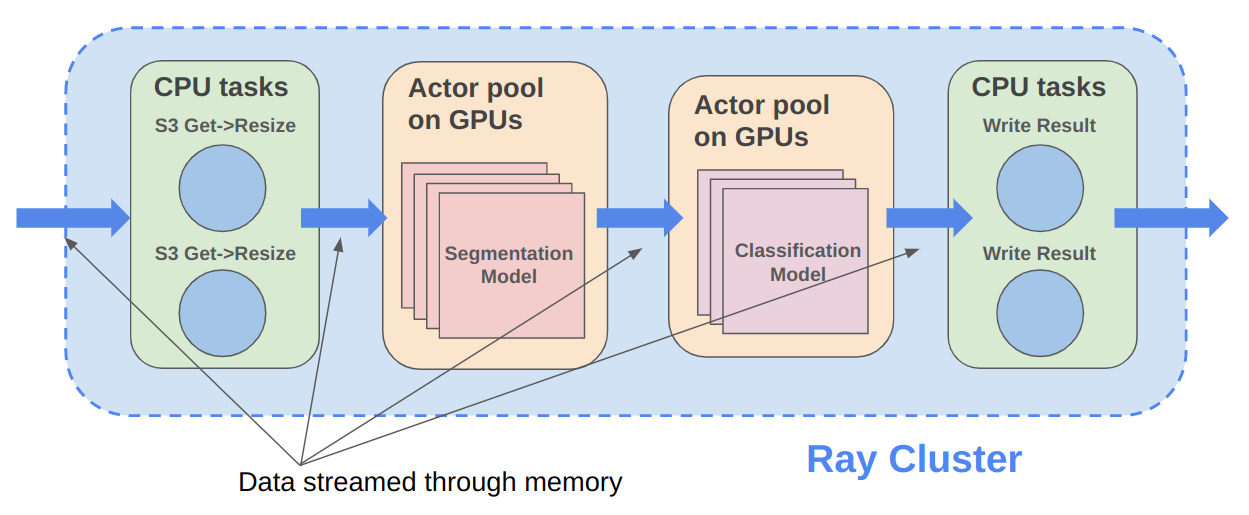

### Offline Batch Inference

The concept of "Offline Batch Inference" refers to the application of trained machine learning models to new data in a batch processing context. This is in contrast to online or real-time inference, where the model generates predictions for one instance at a time, on-the-fly.



In a real-world data pipeline, you might train a machine learning model on a large dataset and then want to apply that model to a new batch of data to generate predictions. With Ray Data, you can distribute this batch inference task across multiple cores or even multiple machines, speeding up the process significantly when working with large datasets.

Offline batch inference is typically used during the initial training of the model or when you need to generate predictions for a large batch of data at once. It's often used in situations where you don't need the predictions immediately and can afford to wait for the entire batch to be processed. This could be for periodic reporting, updating a static dataset with new predictions, or when first deploying a model to make predictions on existing data.

Ray Data offers an efficient and scalable solution for batch inference, providing faster execution and cost-effectiveness for deep learning applications. For more details on how to use Ray Data for offline batch inference [link](https://docs.ray.io/en/latest/data/overview.html)

The following example provides a basic demonstration of how you can use ray.data for large-scale data preprocessing for ML training. You could extend this pipeline with more transformations specific to your use case. Note that these operations are performed in parallel and can be scaled across multiple nodes in a cluster with Ray, making this tool very powerful for preprocessing large datasets.

In this example, we download historical data of Apple's stock using yfinance, save it as a CSV file, and then create a ray.data.Dataset object from this file. We then define a transformation function compute_moving_average which computes the 10-day moving average of the closing prices. This function is applied to the dataset using the map_batches function. After that, we iterate over the transformed dataset, and finally save it as a parquet file.

In [ ]:
ray.init()

# Downloading stock data using yfinance
data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")

# Save the data to a csv file
data.to_csv("AAPL.csv")

# Create a dataset from the saved csv file
ds = ray.data.read_csv("AAPL.csv")

# Apply function to transform data
def compute_moving_average(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    closing_price = batch["Close"]
    batch["Moving Average (10 days)"] = pd.Series(closing_price).rolling(window=10).mean().values
    return batch

def normalize_close(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    close = batch["Close"]
    batch["Close"] = (close - close.min()) / (close.max() - close.min())
    return batch

In [3]:
transformed_ds = ds.map_batches(compute_moving_average).map_batches(normalize_close)

# Filter out NaN rows
filtered_ds = transformed_ds.filter(lambda row: pd.notna(row["Moving Average (10 days)"]))

# Iterate over batches of data
for batch in filtered_ds.iter_batches(batch_size=10):
    print(batch)

# Save transformed dataset to disk
filtered_ds.write_parquet("../data/AAPL/")
ray.shutdown()


2023-07-22 05:32:32,328	INFO worker.py:1621 -- Started a local Ray instance.


[*********************100%***********************]  1 of 1 completed


2023-07-22 05:32:38,665	INFO read_api.py:374 -- To satisfy the requested parallelism of 4, each read task output will be split into 4 smaller blocks.
2023-07-22 05:32:38,696	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(compute_moving_average)->MapBatches(normalize_close)->Filter(<lambda>)]
2023-07-22 05:32:38,707	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-07-22 05:32:38,716	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

{'Date': array(['2020-01-15', '2020-01-16', '2020-01-17', '2020-01-21',
       '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-27',
       '2020-01-28', '2020-01-29'], dtype='datetime64[D]'), 'Open': array([77.96250153, 78.39749908, 79.06749725, 79.29750061, 79.64499664,
       79.48000336, 80.0625    , 77.51499939, 78.15000153, 81.11250305]), 'High': array([78.875     , 78.92500305, 79.68499756, 79.75499725, 79.99749756,
       79.88999939, 80.83249664, 77.94249725, 79.59999847, 81.96250153]), 'Low': array([77.38749695, 78.02249908, 78.75      , 79.        , 79.32749939,
       78.91249847, 79.37999725, 76.22000122, 78.04750061, 80.34500122]), 'Close': array([0.27843768, 0.29092365, 0.30209708, 0.29518175, 0.2987995 ,
       0.30369785, 0.30075239, 0.27078605, 0.29876746, 0.32005766]), 'Adj Close': array([76.0317688 , 76.98419189, 77.83647156, 77.30900574, 77.58494568,
       77.95859528, 77.73391724, 75.44812775, 77.58251953, 79.20648193]), 'Volume': array([121923600, 108829200, 1

2023-07-22 05:32:42,280	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(compute_moving_average)->MapBatches(normalize_close)->Filter(<lambda>)->Write]
2023-07-22 05:32:42,282	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-07-22 05:32:42,289	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


{'Date': array(['2022-04-14', '2022-04-18', '2022-04-19', '2022-04-20',
       '2022-04-21', '2022-04-22', '2022-04-25', '2022-04-26',
       '2022-04-27', '2022-04-28'], dtype='datetime64[D]'), 'Open': array([170.61999512, 163.91999817, 165.02000427, 168.75999451,
       168.91000366, 166.46000671, 161.11999512, 162.25      ,
       155.91000366, 159.25      ]), 'High': array([171.27000427, 166.6000061 , 167.82000732, 168.88000488,
       171.52999878, 167.86999512, 163.16999817, 162.33999634,
       159.78999329, 164.52000427]), 'Low': array([165.03999329, 163.57000732, 163.91000366, 166.1000061 ,
       165.91000366, 161.5       , 158.46000671, 156.72000122,
       155.38000488, 158.92999268]), 'Close': array([0.74904563, 0.74484743, 0.78931282, 0.78606858, 0.77061061,
       0.68225174, 0.70305349, 0.58702292, 0.58263369, 0.7175572 ]), 'Adj Close': array([164.06781006, 163.84944153, 166.16223145, 165.99346924,
       165.18943787, 160.59368896, 161.67564392, 155.64059448,
       15

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

- Remember that you need to have the parquet file writer library (pyarrow or fastparquet) installed in your environment to use the write_parquet function.

- Also, please note that this example demonstrates the use of ray.data on a single node setup. For a distributed setup with large scale data processing, you'd use a distributed file system or a cloud storage system like S3 instead of local CSV files.

- Further, we have a new function normalize_close that normalizes the Close prices to the range [0, 1]. We apply this function to the dataset using the map_batches function, just like before. We then use the filter function to remove any rows with NaN in the Moving Average (10 days) column.

